# Introduction

Polyhedron is of great interest to mathematicians partly due to its close relation to the solution
space of linear programming (LP) problems. Among the foundational results that characterize the
algebraic properties of polyhedra is the *fundamental theorem of linear inequalities* (Thm 1), from
which theorems like the finite basis theorem and decomposition theorem can be derived.

**Theorem 1 (Fundamental Theorem of Linear Inequalities)**: Let $a_1,\dots,a_m,b\in\mathbb{R  }^n$. Then:

either

- there exists $\lambda\in\mathbb{R}_+^m$, such that $b=\sum_{i=1}^{m}\lambda_ia_i$;

or

- there exists $c\in\mathbb{R}^n$, such that $c^Tb<0,c^Ta_1,\dots,c^Ta_m\geq 0$ and $c^Ta_j=0$ for $t-1$ linearly independent vectors $a_j$ from $a_1,\dots,a_m$,

where $\mathbb{R}_+$ denotes the nonnegative real numbers and $t\equiv \text{rank}\{a_1,\dots,a_m,b\}$.

In this notebook we follow Schriver's proof [1] of the theorem and implement an algorithm which returns either a $\lambda\in\mathbb{R}_+^m$ or a $c\in\mathbb{R}^n$ satisfying the theorem statement. Moreover, since the algorithm is iterative, an animation will be created to visualize how such a result is progressively found. The algorithm does not assume $\text{span}(a_1,\dots,a_m)=\mathbb{R}^n$ and works for arbitrary $n, m$. The animation, however, is designed for $n=2$ only.

# Preparation
We start by importing necessary packages and defining some helper functions.

In [1]:
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

These functions avoid floating point precesion errors.

In [2]:
def equal(a1, a2):
    return (abs(a1 - a2) < 1e-10).all()

def geq(a1, a2):
    return (a1 > a2 - 1e-10).all()

def greater(a1, a2):
    return (a1 > a2 + 1e-10).all()

This function verifies if the result is correct.

In [3]:
def print_result(case, A, b, lam_or_c):
    if(case == 1):
        assert geq(lam_or_c, 0)
        assert equal(b, A @ lam_or_c)
        print(f'Case 1. lambda = {lam_or_c}')
    elif(case == 2):
        assert greater(0, lam_or_c @ b)
        assert geq(lam_or_c @ A, 0)

        print(f'Case 2. c = {lam_or_c}')

Now, we initialize $n, m, A=(a_1,\dots,a_m)$ and $b$, as per defined in the theorem statement. Free free to change them to any other values you like.

In [4]:
n = 2
m = 4

A = np.random.rand(n, m) * 2 - 1
b = np.random.rand(n) * 2 - 1

Randomly generated matrices has full rank with probability 1.
However, we can manually reduce its rank by manipulating its colomns, e.g.,

In [5]:
# A[:, 3] = A[:, 0] + A[:, 1] - A[:, 2]

If $(a_1,\dots,a_m)$ does not span $\mathbb{R}^n$, we isometrically transform $a_i\to a_i'=(\dots,0)^T$ and then delete the last dimension.

If the last dimension of $b'$ is non-zero, it follows immediately that $b$ is linearly independent of $(a_1,\dots,a_m)$ and the seperating hyperplane is simply $(0,\dots,0,1)$. Therefore, there is no need to proceed to the main algorithm. After this step, we should have $n\leq m$.

In [6]:
if(np.linalg.matrix_rank(A) < n):
    u, s, _ = np.linalg.svd(A)
    rank = sum(abs(s > 1e-10))
    nA = u.T @ A
    nb = u.T @ b
    assert equal(nA[rank:], 0)

    if(not equal(nb[rank:], 0)):
        c = -nb
        c[:rank] = 0
        c = u @ c
        print_result(2, A, b, c)
    else:
        n = rank
        A = nA[:rank]
        b = nb[:rank]
    print('Dimension reduced')

In the 2D case, we draw <span style="color:blue">$a_i$</span>'s and <span style="color:red">$b$</span> in the following plot.

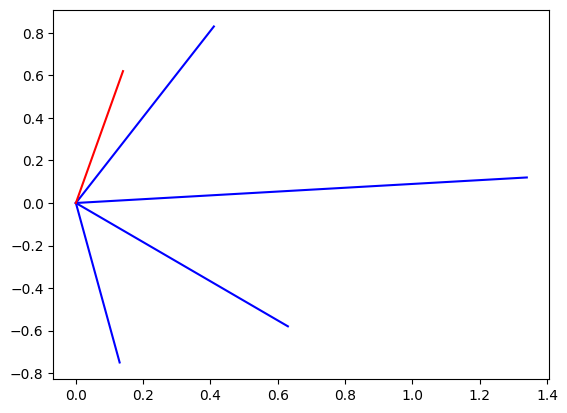

In [7]:
assert n == 2, 'Visualization only works for n == 2.'

for p in A.T:
    plt.plot([0,p[0]], [0,p[1]], c='b', alpha=1)
plt.plot([0,b[0]], [0,b[1]], c='r')
plt.show()

# The Solver

Now, we are ready to implement the solver.

Below is the pseudocode:

- Pick a linearly independent subset $D$ of $\{a_1, ..., a_m\}$ with $n$ elements.

- `while(true)`:

    1. Find $\lambda\in\mathbb{R}^n$ such that $b=\lambda^T D$. If $\lambda\in\mathbb{R}^n_{+}$, exit with case 1.
    
    2. $h\gets \min_i\{i:\lambda_i<0\}$. Find $c\in\mathbb{R}^n$ such that $c^Ta_i=\begin{cases}0, \text{if }i\neq h \\ 1, \text{if }i=h\end{cases},\forall a_i\in D$.
    
    3. If $c^Ta_i\geq 0, \forall a_i\in\{a_1,\dots,a_m\}$, exit with case 2.
    
    4. $s\gets \min_i\{i:c^Ta_i<0, a_i\in\{a_1,\dots,a_m\}\}$. Substitute $a_s$ for $a_h$ in $D$.

In [8]:
def solve(A, b):
    # These global variables store the intermediary results
    # and are only used when drawing animations 
    global poly, cc, ss
    
    # Pick a linearly independent subset of {a_1, ..., a_m}
    for c in combinations(range(m), n):
        D = A[:,c]

        # Linear dependence means vanishing determinant
        if(not equal(np.linalg.det(D), 0)):
            D = D.copy()
            break

    
    while(True):
        poly = np.concatenate([poly, D.reshape([1,n,n])])

        # -------- Step (1) -------- 
        # The following trick computes lambda
        lam = np.linalg.inv(D) @ b
        if(geq(lam, 0)):
            print_result(1, D, b, lam)
            return 1, lam
            
        
        # -------- Step (2) -------- 
        h = (lam < -1e-10).argmax()

        # The following trick computes c
        u, _, _ = np.linalg.svd(np.delete(D, h, 1))
        c = u.T[-1]

        # Normalize c
        c /= c @ D[:,h]
        cc = np.vstack([cc, c])


        # -------- Step (3) --------
        ca = c @ A
        if(geq(ca, 0)):
            print_result(2, A, b, c)
            return 2, c

        # -------- Step (4) -------- 
        s = (ca < -1e-8).argmax()
        ss = np.vstack([ss, A[:,s].T])

        D[:,h] = A[:,s]

In [9]:
# Initialize intermediary data storage pool.
poly = np.empty([0, n, n])
cc = np.empty([0, n])
ss = np.empty([0, n])

# Call the solver
case, res = solve(A, b)

Case 2. c = [ 1.0911003  -0.53897726]


# Animation
Below we create an animation using `matplotlib.animation` package to visualize how this iterative solver works. The animation is 2D and only works when **n == 2**.

In [10]:
assert n == 2, 'n is not equal to 2'

In [11]:
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

plt.rcParams["animation.html"] = "jshtml"

We first define functions which draw the artifacts.

In [12]:
def draw_poly(i):
    zero = np.zeros([2])

    vert = np.vstack([zero, poly[i].T * 100, zero])
    codes = np.array([2]*len(vert), dtype='uint8')
    codes[0], codes[-1] = 1, 79
    path = shade.get_paths()[0]
    path.vertices = vert
    path.codes = codes

def rotate_poly(i, f):
    zero = np.zeros([2])

    v1, v2 = poly[i].T
    v1n, v2n = poly[i+1].T
    fix, next = (v1n, v2n) if np.linalg.norm(v2n - ss[i])<1e-8 else (v2n, v1n)
    prev = v1 if np.linalg.norm(v2 - fix)<1e-8 else v2

    fix, next, prev = fix/np.linalg.norm(fix), next/np.linalg.norm(next), prev/np.linalg.norm(prev)
    if(np.cross(fix, prev) * np.cross(fix, next) , 0):
        mid = (prev+next) / 2
        if(mid @ fix < 0):
            mid *= -1
        cur = f * mid + (0.5-f) * prev if f < 0.5 else (1-f) * mid + (f-0.5) * next
    else:
        cur = f * next + (1-f) * prev

    vert = np.vstack([zero, fix*100, cur*100, zero])
    codes = np.array([2]*len(vert), dtype='uint8')
    codes[0], codes[-1] = 1, 79
    path = shade.get_paths()[0]
    path.vertices = vert
    path.codes = codes


def draw_line(i, f):
    c = cc[i] / np.linalg.norm(cc[i]) * 0.2
    x = np.linspace(0,c[0], 100) * f
    y = np.linspace(0,c[1], 100) * f
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    line.set_segments(segments)
    
    
def flash(s, f):
    if(0.2 <= f < 0.4 or 0.6<= f < 0.8):
        white.set_data([[0, s[0]], [0, s[1]]])
    else:
        white.set_data([[], []])

def clear_line():
    line.set_segments([])

The following function defines the timeline of the animation

In [13]:
def animate(frame):
    i = frame // timer_cum[-1]
    f = frame % timer_cum[-1]
    
    if(f == 1):
        draw_poly(i)
        
    ff = (f-timer_cum[0])/timer[1]
    if(0 <= ff < 1 and i < len(cc)):
        draw_line(i, ff)

    ff = (f-timer_cum[1])/timer[2]
    if(0 <= ff < 1):
        if(i < len(ss)):
            flash(ss[i], ff)
        elif(i == len(poly)-1):
            flash(b, ff)
        
    if(f == timer_cum[2] and i != len(poly)-1):
        clear_line()

    ff = (f-timer_cum[2])/timer[3]
    if( 0 <= ff < 1 and i < len(ss)):
        rotate_poly(i, ff)
        
    return shade, line

Now, we are ready to draw the animation. You should get a gif by executing the following block.

In the animation, 

- the <span style="color:#99ccff">blue block</span> represents the current polyhedron $D$;

- the <span style="color:#10B7C3">cyan shade</span> represents the (oriented) hyperplane $c$;

- the flashing line represents the current vector in interest.

In [ ]:
fig, ax = plt.subplots()

for p in A.T:
    plt.plot([0,p[0]], [0,p[1]], c='b')

plt.plot([0,b[0]], [0,b[1]], c='r')

white = plt.plot([0,0],[0,0], c='w')[0]
shade = plt.fill_between([0], [0], 0, facecolor = '#e6e6ff')
line = ax.add_collection(LineCollection(
            np.empty([0,2,2]), linewidths=1000, 
            alpha=0.7*np.linspace(1,0,100), color='#10B7C3', animated=True))

fps = 30

timer = np.array([30, 30, 50 ,50])
timer_cum = np.cumsum(timer)

plt.axis('scaled')

ani = animation.FuncAnimation(
    fig, animate, interval=1000//fps, blit=True, save_count=len(poly)*timer_cum[-1])

ani

Run the following code to save your animation.

In [15]:
ani.save("animation.mp4")

----------------
# References
[1] Alexander Schrijver. *Theory of Linear and Integer Programming*. John Wiley & Sons, Chichester, 1998.